In [0]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [0]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import cv2
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [0]:
def load_testing():
    """
    Load test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images,labels

def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

# Load test images
test_images, test_labels= load_testing()
test_images_vgg, _ = load_testing()

# Remap test labels
test_labels = np.array([remap_label(l) for l in test_labels])

# Convert the labels to categorical format
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Number of images
n_test_img = test_images.shape[0]

# Compute width and height of images
img_w = test_images.shape[1]
img_h = test_images.shape[2]

# Create a new dimension for color in the images arrays
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))
test_images_vgg = test_images_vgg.reshape((n_test_img, img_w, img_h, 1))

# Rescale values to (0-1), or (0-255) for VGG
test_images = test_images.astype('uint16') / 65535
test_images_vgg = test_images_vgg.astype('uint16') / 256

# Replicate the only channel 3 times for VGG16
test_images_vgg = np.repeat(test_images_vgg, 3, axis=3)

# Normalize VGG images
preprocess_input(test_images_vgg);

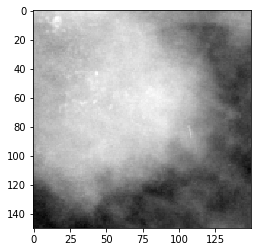

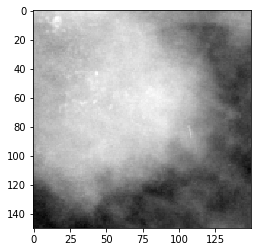

In [0]:
# Make sure images are still ok

idx = 0

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.figure()

plt.imshow(test_images_vgg[idx][:,:,0]/256, cmap='gray')
plt.show()

In [0]:
!cp "/content/gdrive/My Drive/models/model_1_4cl_best.h5" .
!cp "/content/gdrive/My Drive/models/model_2_4cl_best.h5" .
!cp "/content/gdrive/My Drive/models/model_3_4cl_best.h5" .
!cp "/content/gdrive/My Drive/models/vgg16_ft_3layer_4cl_best.h5" .

model1 = models.load_model('model_1_4cl_best.h5');
model2 = models.load_model('model_2_4cl_best.h5');
model3 = models.load_model('model_3_4cl_best.h5');
modelvgg = models.load_model('vgg16_ft_3layer_4cl_best.h5');

In [0]:
_, acc1 = model1.evaluate(test_images, test_labels, verbose=False)
_, acc2 = model2.evaluate(test_images, test_labels, verbose=False)
_, acc3 = model3.evaluate(test_images, test_labels, verbose=False)
_, accvgg = modelvgg.evaluate(test_images_vgg, test_labels, verbose=False)

## Ensemble 1

This ensemble is composed of the three 4-class models developed from scratch.

In [0]:
ensemble1_cl = np.array([
        np.squeeze(model1.predict_classes(test_images)).tolist(), 
        np.squeeze(model2.predict_classes(test_images)).tolist(), 
        np.squeeze(model3.predict_classes(test_images)).tolist() 
        ]
)

ensemble1_pred = np.array([
        np.squeeze(model1.predict(test_images)).tolist(), 
        np.squeeze(model2.predict(test_images)).tolist(), 
        np.squeeze(model3.predict(test_images)).tolist()
        ]
)

In [0]:
# Accuracy by voting
ensemble1_voting_pred = np.array([Counter([ensemble1_cl[m][e] for m in range(len(ensemble1_cl))]).most_common(1)[0][0] for e in range(n_test_img)])
ensemble1_voting_right = sum([p == l for p, l in zip(ensemble1_voting_pred, test_labels_raw)])
ensemble1_voting_acc = ensemble1_voting_right / n_test_img

# Accuracy by averaging
ensemble1_avg_pred = np.array([np.argmax(sum([ensemble1_pred[m][e] for m in range(len(ensemble1_pred))])) for e in range(n_test_img)])
ensemble1_avg_right = sum([p == l for p, l in zip(ensemble1_avg_pred, test_labels_raw)])
ensemble1_avg_acc = ensemble1_avg_right / n_test_img

print("\nM1")
print(ensemble1_cl[0])
print("Acc: %.4f" % acc1)
print("\nM2")
print(ensemble1_cl[1])
print("Acc: %.4f" % acc2)
print("\nM3")
print(ensemble1_cl[2])
print("Acc: %.4f" % acc3)
print("\nEnsemble")
print(ensemble1_voting_pred)

print("Voting accuracy: %.4f" % ensemble1_voting_acc)
print("Averaging accuracy: %.4f" % ensemble1_avg_acc)


M1
[1 3 0 0 1 1 3 1 1 0 3 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 2 3 0 0 2 2
 0 0 1 3 2 0 0 0 1 0 3 3 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 3 0 3 0 2 0 0 1
 1 0 1 1 1 1 1 0 0 0 0 3 1 3 0 1 1 2 0 1 0 1 1 0 1 0 0 1 1 3 3 2 0 1 1 1 0
 1 0 0 0 0 1 1 0 0 1 0 1 3 0 0 1 0 1 1 1 1 1 0 3 0 0 0 1 2 0 1 3 0 1 0 0 1
 1 0 0 1 0 0 0 0 0 0 0 3 1 0 2 1 3 2 0 0 1 0 0 0 0 0 1 1 2 2 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 2 3 2 3 0 2 2 2 0 0 2 2 2 3 2 2 2 2 1 1 3 1 3 3 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 3 2 2 2 2 2 2 3 3 1 1 3 3 2 2 2 3 3 3 3 3 3 3 3 3 3
 3 2 2 2 2 3 3 3 2 2 2 2 2 2 2 2 2 1 2 3 2 3 3 3 3 2 2 3 3 3 2 2 3 3 1 2 2
 2 2 3 1 3 3 2 2 2 2 3 2 2 2 2 1 3 2 2 2 2 2 2 3 2 3 2 2 2 2 3 2 3 3 1 3 2
 2 2 2]
Acc: 0.5774

M2
[1 3 0 0 1 1 3 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 2 0 0 0 2 2
 0 0 0 1 0 0 0 1 1 2 3 3 3 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 2 0 2 0 0 0 0 1
 3 0 1 1 1 1 1 0 0 0 0 3 1 2 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 3 3 0 0 1 1 1 0
 0 2 0 0 1 1 1 1 0 1 0 1 3 0 1 1 0 1 1 1 0 1 1 2 0 0 0 1 2 0 1 1 1 1 0 1

**Result**: Averaging did not improve the accuracy at all, while voting made it even worse with respect to the best individual model. This demonstrates that ensembles often lead to better results, but they are not guaranteed to do so; in some unfortunate cases, like this, an ensemble can perform worse.

## Ensemble 2

The 4-class fine-tuned VGG model is added to the previous ensemble. Since the number of classifiers is now even, voting would not be predictable; averaging is the most natural choice here.

In [0]:
ensemble2_cl = np.array([
        np.squeeze(model1.predict_classes(test_images)).tolist(), 
        np.squeeze(model2.predict_classes(test_images)).tolist(), 
        np.squeeze(model3.predict_classes(test_images)).tolist(),
        np.squeeze(modelvgg.predict_classes(test_images_vgg)).tolist()
        ]
)

ensemble2_pred = np.array([
        np.squeeze(model1.predict(test_images)).tolist(), 
        np.squeeze(model2.predict(test_images)).tolist(), 
        np.squeeze(model3.predict(test_images)).tolist(),
        np.squeeze(modelvgg.predict(test_images_vgg)).tolist()
        ]
)

In [0]:
# Accuracy by averaging
ensemble2_avg_pred = np.array([np.argmax(sum([ensemble2_pred[m][e] for m in range(len(ensemble2_pred))])) for e in range(n_test_img)])
ensemble2_avg_right = sum([p == l for p, l in zip(ensemble2_avg_pred, test_labels_raw)])
ensemble2_avg_acc = ensemble2_avg_right / n_test_img

print("\nM1")
print(ensemble2_cl[0])
print("Acc: %.4f" % acc1)

print("\nM2")
print(ensemble2_cl[1])
print("Acc: %.4f" % acc2)

print("\nM3")
print(ensemble2_cl[2])
print("Acc: %.4f" % acc3)

print("\nVGG")
print(ensemble2_cl[3])
print("Acc: %.4f" % accvgg)

print("\nEnsemble")
print(ensemble2_avg_pred)

print("Averaging accuracy: %.4f" % ensemble2_avg_acc)


M1
[1 3 0 0 1 1 3 1 1 0 3 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 2 3 0 0 2 2
 0 0 1 3 2 0 0 0 1 0 3 3 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 3 0 3 0 2 0 0 1
 1 0 1 1 1 1 1 0 0 0 0 3 1 3 0 1 1 2 0 1 0 1 1 0 1 0 0 1 1 3 3 2 0 1 1 1 0
 1 0 0 0 0 1 1 0 0 1 0 1 3 0 0 1 0 1 1 1 1 1 0 3 0 0 0 1 2 0 1 3 0 1 0 0 1
 1 0 0 1 0 0 0 0 0 0 0 3 1 0 2 1 3 2 0 0 1 0 0 0 0 0 1 1 2 2 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 2 3 2 3 0 2 2 2 0 0 2 2 2 3 2 2 2 2 1 1 3 1 3 3 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 3 2 2 2 2 2 2 3 3 1 1 3 3 2 2 2 3 3 3 3 3 3 3 3 3 3
 3 2 2 2 2 3 3 3 2 2 2 2 2 2 2 2 2 1 2 3 2 3 3 3 3 2 2 3 3 3 2 2 3 3 1 2 2
 2 2 3 1 3 3 2 2 2 2 3 2 2 2 2 1 3 2 2 2 2 2 2 3 2 3 2 2 2 2 3 2 3 3 1 3 2
 2 2 2]
Acc: 0.5774

M2
[1 3 0 0 1 1 3 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 2 0 0 0 2 2
 0 0 0 1 0 0 0 1 1 2 3 3 3 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 2 0 2 0 0 0 0 1
 3 0 1 1 1 1 1 0 0 0 0 3 1 2 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 3 3 0 0 1 1 1 0
 0 2 0 0 1 1 1 1 0 1 0 1 3 0 1 1 0 1 1 1 0 1 1 2 0 0 0 1 2 0 1 1 1 1 0 1

**Result**: The addition of another model didn't change the classification accuracy, which is stuck at 61.3\%.

# Weighted ensemble (with grid search)

The previous averaging ensemble gave the same importance to all the four models, although this is not always the best option. A good ensemble should encourage diversity, that is models whose predictions are positively correlated for the correct samples and negatively correlated for the mistakes.
By assigning different weights to each model, the final ensemble may give better results; the challenge is indeed to find the best combination of such weights.
A simple approach in this sense is *grid search*, which is basically an exhaustive search through a subset of all the possible configurations. Hold-out can be used have a validation set where to measure the goodness of the weights, and a testing set to evaluate the actual accuracy.

For this dataset, since the test set is already small, splitting it into two subsets (validation and testing) could easily end up in distribution asymmetries that would nullify any result from a statistical point of view. To avoid this situation, the average accuracy obtained on validation and test set is monitored: if they differ too much, it means that one subset contains more hard samples than the other, and the experiment should be repeated with a different partitioning.

In this case the testing set is split in half. Grid search is performed on the 4-ensemble with weights ranging from 0 to 1 in steps of 0.1.
The combination that gets the best accuracy on the validation set is selected as optimal and evaluated on the test set. Since the predictions of each network for each sample can be precomputed (and scaled later for averaging), the overall search is relatively fast.

In [0]:
seed = 42

gs_valid_img, gs_test_img, gs_valid_label_raw, gs_test_label_raw = train_test_split(test_images, test_labels_raw, test_size=0.5, random_state=seed)
gs_valid_img_vgg, gs_test_img_vgg, _, _ = train_test_split(test_images_vgg, test_labels_raw, test_size=0.5, random_state=seed)

gs_n_valid_img = len(gs_valid_img)
gs_n_test_img = len(gs_test_img)

print("Grid search validation set size: %d" % gs_n_valid_img)
print("Grid search test set size: %d" % gs_n_test_img)

Grid search validation set size: 168
Grid search test set size: 168


In [0]:
gs_ensemble_valid_pred = np.array([
        np.squeeze(model1.predict(gs_valid_img)).tolist(), 
        np.squeeze(model2.predict(gs_valid_img)).tolist(), 
        np.squeeze(model3.predict(gs_valid_img)).tolist(),
        np.squeeze(modelvgg.predict(gs_valid_img_vgg)).tolist()
        ]
)

gs_ensemble_test_pred = np.array([
        np.squeeze(model1.predict(gs_test_img)).tolist(), 
        np.squeeze(model2.predict(gs_test_img)).tolist(), 
        np.squeeze(model3.predict(gs_test_img)).tolist(),
        np.squeeze(modelvgg.predict(gs_test_img_vgg)).tolist()
        ]
)

In [0]:
best_acc = 0
best_weights = ()

tot_valid_acc = 0
tot_test_acc = 0
n_comb = 0

for a in np.arange(0, 1.01, 0.1):
    for b in np.arange(0, 1.01-a, 0.1):
        for c in np.arange(0, 1.01-a-b, 0.1):
            d = max(0, 1-a-b-c)
            w = (a,b,c,d)
            gs_ensemble_avg_valid_pred = np.array([np.argmax(sum([w[m]*gs_ensemble_valid_pred[m][e] for m in range(len(gs_ensemble_valid_pred))])) for e in range(gs_n_valid_img)])
            gs_ensemble_avg_valid_right = sum([p == l for p, l in zip(gs_ensemble_avg_valid_pred, gs_valid_label_raw)])
            gs_ensemble_avg_valid_acc = gs_ensemble_avg_valid_right / gs_n_valid_img

            if gs_ensemble_avg_valid_acc > best_acc:
                best_acc = gs_ensemble_avg_valid_acc
                best_weights = w

            gs_ensemble_avg_test_pred = np.array([np.argmax(sum([w[m]*gs_ensemble_test_pred[m][e] for m in range(len(gs_ensemble_test_pred))])) for e in range(gs_n_test_img)])
            gs_ensemble_avg_test_right = sum([p == l for p, l in zip(gs_ensemble_avg_test_pred, gs_test_label_raw)])
            gs_ensemble_avg_test_acc = gs_ensemble_avg_test_right / gs_n_test_img

            tot_valid_acc +=  gs_ensemble_avg_valid_acc
            tot_test_acc += gs_ensemble_avg_test_acc
            n_comb += 1

            print("(%.1f, %.1f, %.1f, %.1f) \t Val: %.3f   Test: %.3f" % (a,b,c,d,gs_ensemble_avg_valid_acc, gs_ensemble_avg_test_acc))

gs_ensemble_avg_test_pred = np.array([np.argmax(sum([best_weights[m]*gs_ensemble_test_pred[m][e] for m in range(len(gs_ensemble_test_pred))])) for e in range(gs_n_test_img)])
gs_ensemble_avg_test_right = sum([p == l for p, l in zip(gs_ensemble_avg_test_pred, gs_test_label_raw)])
gs_ensemble_avg_test_acc = gs_ensemble_avg_test_right / gs_n_test_img

avg_valid_acc = tot_valid_acc / n_comb
avg_test_acc = tot_test_acc / n_comb

print("Avg valid acc: %.3f     Avg test_acc: %.3f" % (avg_valid_acc, avg_test_acc))
print("Optimal weights: (%.1f, %.1f, %.1f, %.1f)  Test Accuracy: %.3f" % (*best_weights, gs_ensemble_avg_test_acc))

(0.0, 0.0, 0.0, 1.0) 	 Val: 0.589   Test: 0.595
(0.0, 0.0, 0.1, 0.9) 	 Val: 0.601   Test: 0.601
(0.0, 0.0, 0.2, 0.8) 	 Val: 0.613   Test: 0.613
(0.0, 0.0, 0.3, 0.7) 	 Val: 0.619   Test: 0.631
(0.0, 0.0, 0.4, 0.6) 	 Val: 0.619   Test: 0.631
(0.0, 0.0, 0.5, 0.5) 	 Val: 0.643   Test: 0.637
(0.0, 0.0, 0.6, 0.4) 	 Val: 0.631   Test: 0.643
(0.0, 0.0, 0.7, 0.3) 	 Val: 0.631   Test: 0.643
(0.0, 0.0, 0.8, 0.2) 	 Val: 0.643   Test: 0.643
(0.0, 0.0, 0.9, 0.1) 	 Val: 0.631   Test: 0.613
(0.0, 0.0, 1.0, 0.0) 	 Val: 0.625   Test: 0.595
(0.0, 0.1, 0.0, 0.9) 	 Val: 0.595   Test: 0.607
(0.0, 0.1, 0.1, 0.8) 	 Val: 0.613   Test: 0.619
(0.0, 0.1, 0.2, 0.7) 	 Val: 0.619   Test: 0.631
(0.0, 0.1, 0.3, 0.6) 	 Val: 0.631   Test: 0.631
(0.0, 0.1, 0.4, 0.5) 	 Val: 0.637   Test: 0.631
(0.0, 0.1, 0.5, 0.4) 	 Val: 0.637   Test: 0.637
(0.0, 0.1, 0.6, 0.3) 	 Val: 0.625   Test: 0.637
(0.0, 0.1, 0.7, 0.2) 	 Val: 0.643   Test: 0.643
(0.0, 0.1, 0.8, 0.1) 	 Val: 0.637   Test: 0.637
(0.0, 0.1, 0.9, 0.0) 	 Val: 0.625   Test

The optimization procedure returned (0.2, 0.1, 0.2, 0.5) as the optimal combinations of weights to associate to the ensemble models. With an average accuracy of 61.8\% on the validation set and 61.1\% on the test one, the partitioning appears to be fair, not excessively biased towards any subset.
These weights score a 62.5\% accuracy on the new test set, which is a good improvement w.r.t. individual models and the previous ensembles.